In [1]:
%pylab inline
import skimage
from skimage.io import imread
import cv2
from pathlib import Path
import pandas as pd
import seaborn as sns
pd.__version__

Populating the interactive namespace from numpy and matplotlib


'0.25.3'

 ## Uložení do souboru

In [69]:
ann_fn = Path("annotation.xlsx")
sheet_name = "Sheet1"
if ann_fn.exists():
    dfold = pd.read_excel(str(ann_fn), sheet_name=sheet_name)
        # dfout = pd.concat([dfin, df], axis=0, ignore_index=True)
    dfcombine = dfold.append(df_one_video, ignore_index=True, sort=True)
    dfcombine.to_excel(str(ann_fn), sheet_name=sheet_name, index=False)
else:
    df_one_video.to_excel(ann_fn, index=False, sheet_name=sheet_name)
    

'2020-03-18 18:33:54.220918'

# Návrh

* Limity
* Požadované vstupy
* Návrh API

# Dodatečné informace
 * Rozměr boxu je 180x110 cm

# Vyhodnocení

In [2]:
df_algorithm = pd.DataFrame(dict(
#     filename=["zverinec02-006.mp4"]*8,
    filename=["zverinec02-004.mp4"]*8,
    frame_id=[1, 3, 30, 50, 70,100, 203, 280],
    animal_id=[0, 1, 1, 1, 1, 0, 0, 0],
    x_px=[450, 460, 470, 500, 520, 455, 460, 500],
    y_px=[430, 440, 390, 385, 380, 425, 410, 400],
))

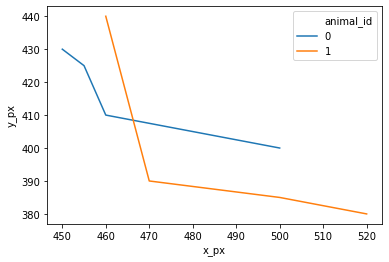

In [3]:
sns.lineplot(data=df_algorithm, x="x_px", y="y_px",hue="animal_id", sort=False)

562


,filename,frame_id,animal_id,x_px,y_px
0,zverinec02-004.mp4,0,0,450.000000,430.000000
1,zverinec02-004.mp4,1,0,450.000000,430.000000
2,zverinec02-004.mp4,2,0,450.461680,430.067749
3,zverinec02-004.mp4,3,0,450.684340,430.098489
4,zverinec02-004.mp4,4,0,450.901618,430.127154
...,...,...,...,...,...
557,zverinec02-004.mp4,276,1,520.000000,380.000000
558,zverinec02-004.mp4,277,1,520.000000,380.000000
559,zverinec02-004.mp4,278,1,520.000000,380.000000
560,zverinec02-004.mp4,279,1,520.000000,380.000000


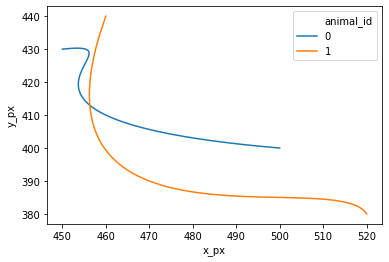

In [3]:
from typing import Optional

def interpolate_px(df_algorithm:pd.DataFrame, n_frames:Optional[int]=None, n_animals:Optional[int]=None, order:int=3) -> pd.DataFrame:
    if n_frames:
        l = n_frames
    else:
        l = np.max(df_algorithm.frame_id) + 1
    if not n_animals:
        n_animals = np.max(df_algorithm.animal_id)
    df_interpolated = pd.DataFrame()

    for fn_i in df_algorithm.filename.unique():
        for animal_id_i in range(0, n_animals+1):
            df_append = pd.DataFrame(dict(
                filename=[fn_i] * l,
                frame_id=list(range(l)),
                animal_id=[animal_id_i] * l,
                x_px=[np.nan] * l,
                y_px=[np.nan] * l,
            ))

            one_to_append = df_algorithm[
                (df_algorithm.animal_id==animal_id_i) & (df_algorithm.filename==fn_i)
            ].append(df_append).sort_values(
                by=["frame_id", "y_px"]
            ).reset_index(drop=True).drop_duplicates( 
                "frame_id" 
            ).interpolate( # this is not putting data in front or to the back
                    method='polynomial', order=order,
    #                 limit_area=None,limit_direction="forward"
            ).interpolate( # this will fill the data
                limit_area=None,limit_direction="backward"
            ).interpolate(
                limit_area=None,limit_direction="forward"
            )

            df_interpolated = df_interpolated.append(
                one_to_append, sort=False
            )
    df_interpolated = df_interpolated.sort_values(by=["filename" ,  "animal_id", "frame_id", ]).reset_index(drop=True)
    return df_interpolated

df_interpolated = interpolate_px(df_algorithm)
sns.lineplot(data=df_interpolated, x="x_px", y="y_px",hue="animal_id", sort=False)

print(len(df_interpolated))

df_interpolated
# one_to_append

In [4]:
df_anns = pd.read_excel("G:/Můj disk/data/medical/orig/zverinec-top-view/annotations/annotations.xlsx")
df_anns.sort_values("filename").filename.unique()

array(['zverinec01-001.mp4', 'zverinec01-002.mp4', 'zverinec01-003.mp4',
       'zverinec01-004.mp4', 'zverinec01-005.mp4', 'zverinec01-006.mp4',
       'zverinec01-007.mp4', 'zverinec01-008.mp4', 'zverinec01-009.mp4',
       'zverinec01-010.mp4', 'zverinec01-011.mp4', 'zverinec01-021.mp4',
       'zverinec01-022.mp4', 'zverinec01-023.mp4', 'zverinec01-024.mp4',
       'zverinec01-025.mp4', 'zverinec01-026.mp4', 'zverinec01-027.mp4',
       'zverinec01-028.mp4', 'zverinec01-029.mp4', 'zverinec01-030.mp4',
       'zverinec02-001.mp4', 'zverinec02-002.mp4', 'zverinec02-003.mp4',
       'zverinec02-004.mp4', 'zverinec02-009.mp4', 'zverinec02-010.mp4',
       'zverinec02-011.mp4', 'zverinec02-012.mp4'], dtype=object)

In [5]:
import contextlib
with contextlib.redirect_stdout(None):
   import pixiedust

In [6]:
%%pixie_debugger
fn_un = df_algorithm.filename.unique()
fn_un

In [21]:
# %%pixie_debugger
# fn_i = 0

def dist_eval(df_gt, df_algorighm):
    df_anns = df_gt
    fns = []
    dst_max = []
    dst_std = []
    dst_mean = []
    anim_ids = []
    debug_per = []
    for fn in df_algorithm.filename.unique():
        df_anns_sel = df_anns[df_anns.filename==fn]
        n_frames = maximum(np.max(df_anns_sel.frame_id), np.max(df_algorithm.frame_id)) + 1
        n_animals= maximum(np.max(df_anns_sel.animal_id), np.max(df_algorithm.animal_id)) + 1

        anim_i = 0
        anim_j = 0

        df_an_s_fn = interpolate_px(df_anns[(df_anns.filename == fn)], n_frames=n_frames, n_animals=n_animals)
        df_al_s_fn = interpolate_px(df_algorithm[(df_algorithm.filename == fn)], n_frames=n_frames, n_animals=n_animals)
        for anim_i in range(n_animals):
            dist_mean = None
            dist_min = 0
            dist_std = 0
            for anim_j in range(n_animals):

                df_an_s = df_an_s_fn[(df_an_s_fn.animal_id==anim_j)]
                df_al_s = df_al_s_fn[(df_al_s_fn.animal_id==anim_i)]

                per_fram_dist = ((df_an_s.x_px - df_al_s.x_px)**2 + (df_an_s.y_px - df_al_s.y_px)**2)**0.5
                debug_per.append(per_fram_dist)

                mn = np.mean(per_fram_dist)
#                 print(f"mn={mn} , {type(mn)} {mn is nan}")

                if mn is not np.nan:
                    if dist_mean is None:
                        dist_mean = np.mean(per_fram_dist)
                        dist_std = np.std(per_fram_dist)
                        dist_max = np.max(per_fram_dist)
    #                     print(f"dist_mean={dist_mean} in init")
                    else:
                        if mn < dist_mean:
                            dist_mean = np.mean(per_fram_dist)
                            dist_std = np.std(per_fram_dist)
                            dist_max = np.max(per_fram_dist)
    #                         print(f"dist_mean={dist_mean} in else")
            fns.append(fn)
            dst_max.append(dist_max)
            dst_std.append(dist_std)
            dst_mean.append(dist_mean)
    #         print(f"dist_mean={dist_mean}")
            anim_ids.append(anim_i)

    df = pd.DataFrame(dict(filename=fns, animal_id=anim_ids, dist_max=dst_max, dist_std=dst_std, dist_mean=dst_mean))
    return df

dist_eval(df_anns, df_algorithm)

,filename,animal_id,dist_max,dist_std,dist_mean
0,zverinec02-004.mp4,0,228.093900,50.802342,90.113597
1,zverinec02-004.mp4,1,233.740627,24.954252,138.020388


## vyhodnocení neznámého algoritmu

In [ ]:
df_alg = pd.read_excel()

dist_eval(df_anns, df_alg)